In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# load the sales data set
sales_data = pd.read_csv('../../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Skinbooster'] 


pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 1,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
0,1-11-2015,11,4,2015,2,Injection 14,Skinbooster,Pharmacy 1,London,1,...,0,0,1,0,0,0,0,0,0,0
1,1-11-2015,11,4,2015,1,Injection 14,Skinbooster,Pharmacy 1,London,1,...,0,0,1,0,0,0,0,0,0,0
4,1-11-2015,11,4,2015,4,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
15,1-12-2015,12,4,2015,2,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
16,1-12-2015,12,4,2015,3,Injection 14,Skinbooster,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68616,1-3-2022,3,1,2022,5,Injection 10,Skinbooster,Pharmacy 5,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
68617,1-3-2022,3,1,2022,7,Injection 10,Skinbooster,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1
68618,1-3-2022,3,1,2022,2,Injection 10,Skinbooster,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1
68619,1-3-2022,3,1,2022,1,Injection 10,Skinbooster,Pharmacy 5,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 11',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 6',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Injection 10',
 'Injection 11',
 'Injection 14',
 'Injection 9',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 6' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Pharmacy 11' : 'sum',
    'Injection 9' :'sum',
    'Injection 10' :'sum',
    'Injection 11' :'sum',
    'Injection 14' :'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

sales_data_lagged['Date'] = pd.to_datetime(sales_data_lagged['Date'], format='%d-%m-%Y')


#X_train, X_test, y_train, y_test = train_test_split(sales_data_lagged.loc[:,sales_data_lagged.columns!='Qty'], sales_data_lagged.loc[:,['Date', 'Qty']], test_size=0.2, random_state=42)
X = sales_data_lagged.loc[(sales_data_lagged['Date'] < '2021-12-01')]
y = sales_data_lagged.loc[(sales_data_lagged['Date'] >= '2021-12-01')]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X.loc[:,X.columns!='Qty']
X_test = y.loc[:,y.columns!='Qty']
y_train = X.loc[:,X.columns=='Qty']
y_test = y.loc[:,y.columns=='Qty']

In [4]:
y

,Date,Qty,Pharmacy 1,Pharmacy 2,Pharmacy 3,Pharmacy 4,Pharmacy 5,Pharmacy 6,Pharmacy 7,Pharmacy 8,...,"Scotland, Newcastle",SouthEast,SouthWest,Qty_lag_1,Qty_lag_2,Qty_lag_3,Qty_lag_4,Qty_lag_5,Qty_lag_6,Qty_lag_7
26,2021-12-01,205,0,25,0,2,7,7,4,1,...,9,4,7,271.0,303.0,104.0,1.0,5.0,5.0,367.0
32,2022-02-01,327,1,20,0,3,15,2,2,7,...,8,9,9,54.0,281.0,268.0,4.0,11.0,205.0,271.0
39,2022-03-01,354,2,39,1,2,18,6,3,0,...,23,25,9,136.0,199.0,400.0,7.0,5.0,16.0,327.0


In [5]:
# train an mlp classifier

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']

random_grid_mlpr = {
    'activation' : activation,
    'solver' : solver
}

# mlpr = MLPRegressor()
# mlpr_random = RandomizedSearchCV(
#     estimator=mlpr,
#     param_distributions=random_grid_mlpr,
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     random_state=0
# )
mlpr = MLPRegressor()
mlpr_random = GridSearchCV(
    estimator=mlpr,
    param_grid=random_grid_mlpr,
    cv=5,
    verbose=5
)

In [6]:
mlpr_random.fit(X_train.iloc[:, 2:], y_train['Qty'])


# make predictions for the test data
predictions = mlpr_random.predict(X_test.iloc[:, 2:])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=identity, solver=lbfgs;, score=0.870 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .activation=identity, solver=lbfgs;, score=0.960 total time=   0.2s
[CV 3/5] END .activation=identity, solver=lbfgs;, score=0.952 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages

[CV 4/5] END .activation=identity, solver=lbfgs;, score=0.939 total time=   0.2s
[CV 5/5] END .activation=identity, solver=lbfgs;, score=0.897 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarn

[CV 1/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 2/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 3/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py

[CV 4/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 5/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 1/5] END ..activation=identity, solver=adam;, score=0.925 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ..activation=identity, solver=adam;, score=0.967 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ..activation=identity, solver=adam;, score=0.935 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ..activation=identity, solver=adam;, score=0.962 total time=   0.2s
[CV 5/5] END ..activation=identity, solver=adam;, score=0.906 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=logistic, solver=lbfgs;, score=0.509 total time=   0.6s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .activation=logistic, solver=lbfgs;, score=0.031 total time=   0.8s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .activation=logistic, solver=lbfgs;, score=0.182 total time=   0.9s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .activation=logistic, solver=lbfgs;, score=0.646 total time=   1.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END .activation=logistic, solver=lbfgs;, score=0.499 total time=   0.7s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ...activation=logistic, solver=sgd;, score=0.361 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ...activation=logistic, solver=sgd;, score=0.401 total time=   0.9s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ...activation=logistic, solver=sgd;, score=0.016 total time=   0.7s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ...activation=logistic, solver=sgd;, score=0.208 total time=   0.4s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END ...activation=logistic, solver=sgd;, score=0.464 total time=   0.4s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END .activation=logistic, solver=adam;, score=-1.192 total time=   0.5s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END .activation=logistic, solver=adam;, score=-0.455 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .activation=logistic, solver=adam;, score=-0.649 total time=   0.4s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .activation=logistic, solver=adam;, score=-0.560 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .activation=logistic, solver=adam;, score=-1.195 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .....activation=tanh, solver=lbfgs;, score=0.289 total time=   0.9s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .....activation=tanh, solver=lbfgs;, score=0.227 total time=   0.8s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .....activation=tanh, solver=lbfgs;, score=0.215 total time=   0.7s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .....activation=tanh, solver=lbfgs;, score=0.645 total time=   0.5s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END .....activation=tanh, solver=lbfgs;, score=0.522 total time=   0.6s
[CV 1/5] END .......activation=tanh, solver=sgd;, score=0.207 total time=   0.0s
[CV 2/5] END .......activation=tanh, solver=sgd;, score=0.183 total time=   0.0s
[CV 3/5] END .......activation=tanh, solver=sgd;, score=0.097 total time=   0.0s
[CV 4/5] END .......activation=tanh, solver=sgd;, score=0.077 total time=   0.0s
[CV 5/5] END .......activation=tanh, solver=sgd;, score=0.196 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END .....activation=tanh, solver=adam;, score=-1.103 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END .....activation=tanh, solver=adam;, score=-0.398 total time=   0.3s
[CV 3/5] END .....activation=tanh, solver=adam;, score=-0.616 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .....activation=tanh, solver=adam;, score=-0.519 total time=   0.1s
[CV 5/5] END .....activation=tanh, solver=adam;, score=-1.081 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .....activation=relu, solver=lbfgs;, score=0.851 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .....activation=relu, solver=lbfgs;, score=0.960 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .....activation=relu, solver=lbfgs;, score=0.891 total time=   0.3s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .....activation=relu, solver=lbfgs;, score=0.874 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END .....activation=relu, solver=lbfgs;, score=0.924 total time=   0.1s
[CV 1/5] END ...activation=relu, solver=sgd;, score=-7256.065 total time=   0.0s
[CV 2/5] END activation=relu, solver=sgd;, score=-92041108325639.547 total time=   0.0s
[CV 3/5] END activation=relu, solver=sgd;, score=-2523197603340516644239980888064.000 total time=   0.0s
[CV 4/5] END activation=relu, solver=sgd;, score=-1689777607389368064.000 total time=   0.0s
[CV 5/5] END ..activation=relu, solver=sgd;, score=-48014.169 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ......activation=relu, solver=adam;, score=0.896 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ......activation=relu, solver=adam;, score=0.957 total time=   0.3s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ......activation=relu, solver=adam;, score=0.812 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ......activation=relu, solver=adam;, score=0.847 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\galea\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[CV 5/5] END ......activation=relu, solver=adam;, score=0.907 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - y_test['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

# calculate the mean squared error
mse = mean_squared_error(y_test['Qty'], predictions)
print('MSE:', mse)

# calculate the r2 score
r2_score = r2_score(y_test['Qty'], predictions)
print('R^2 Score:', r2_score)

# calculate explained variance score
explained_variance_score = explained_variance_score(y_test['Qty'], predictions)
print('Explained Variance Score:', explained_variance_score)

# calculate max error
max_error = max_error(y_test['Qty'], predictions)
print('Max Error:', max_error)


print([X_test['Date'].values, y_test['Qty'].values, predictions])

RMSE: 50.13212032537566
MSE: 2513.2294883179434
R^2 Score: 0.4018335697132943
Explained Variance Score: 0.5390782014890902
Max Error: 77.28708993958998
[array(['2021-12-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000'], dtype='datetime64[ns]'), array([205, 327, 354], dtype=int64), array([230.23889516, 296.51406283, 431.28708994])]


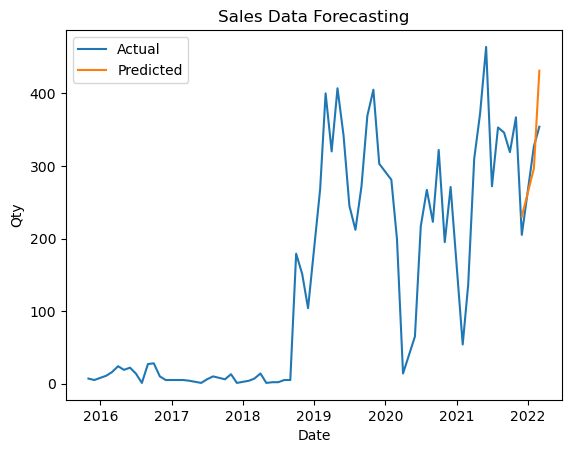

In [8]:

sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=y_test.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [9]:
mlpr_random.best_params_

{'activation': 'identity', 'solver': 'adam'}

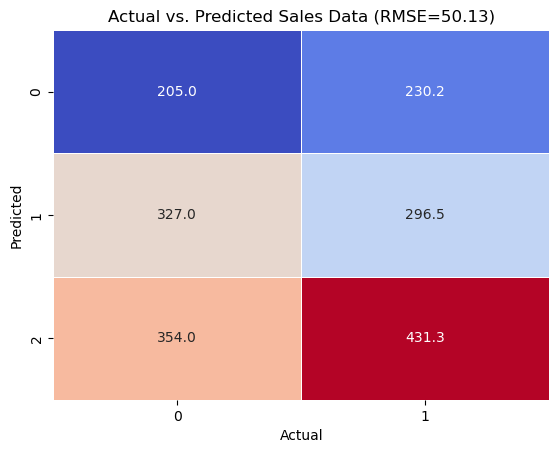

In [10]:
matrix_data = np.column_stack((y_test['Qty'].values, predictions))

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()